# Aula 4 - Métodos Ensemble - Boosting

Nesta aula, vamos conversar sobre os seguintes tópicos:

- 1. Revisão de métodos ensemble - Boosting
- 2. AdaBoost
- 3. Gradient Boosting
- 4. EXtreme Gradiente Boosting - XGBoost

## 1. Revisão de Métodos Ensemble

Os métodos **Ensemble** (do inglês, *ensemble* = conjunto) pertencem a uma classe de modelos de Machine Learning que consiste em *combinar diversos estimadores mais simples* para gerar uma estimativa final mais robusta.

Existem essencialmente três classes de ensemble:

- **Métodos de Agregação:** também conhecidos como *aggregation methods*, têm como procedimento geral construir diversos estimadores independentes e usar a combinação desses estimadores para produzir a predição final. No caso de problemas de regressão, essa combinação pode ser a média aritmética ou ponderada das predições individuais, enquanto que no caso de problemas de classificação, a decisão pode ser tomada por meio da votação majoritária (*hard voting*) ou então pela média arimtética ou ponderada das probabilidades de pertencimento de cada classe  (*soft voting*) O principal objetivo do método é de **reduzir variância**, de modo que o modelo final seja melhor que todos os modelos individuais. Bons exemplos desses modelos são o **Random Forest** e o **Extra Trees**.
- **Métodos de Boosting:** controem modelos robustos por meio da combinação sequencial, de modeo que os estimadores posteriores tentam reduzir o **viés** do estimador conjunto, levando em consideração os erros cometidos pelos estimadores anteriores. Exemplos incluem o **Gradient Boosting** e o **AdaBoost**.
- **Métodos de Stacking:** consistem em "modelos empilhados" de forma hierárquica. Ou seja, o modelo "filho" utiliza como entrada as saídas dos modelos "pais".[Este link](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/) tem mais detalhes sobre a aplicação do método de *stacking ensemble*

No contexto do módulo `scikit-learn`, o [seguinte link](https://scikit-learn.org/stable/modules/ensemble.html) tem a documentação com os modelos ensemble implementados.

## 2. *AdaBoosting*

O *AdaBoost* significa **Adaptative Boosting**, e tem como procedimento geral a criação sucessiva dos chamados *weak learners*,ou modelos de aprendizagem fraca. Um exemplo de modelo de aprendizagem fraca no caso de modelos em árvores de um único nó (**stumps**).

<img src="https://miro.medium.com/max/1744/1*nJ5VrsiS1yaOR77d4h8gyw.png" width=300>

O AdaBoost utiliza os erros da árvore anterior para **melhorar a próxima árvore**. As predições finais são feitas com base **nos pesos de cada stump**, cuja determinação faz parte do algoritmo.

<img src="https://static.packt-cdn.com/products/9781788295758/graphics/image_04_046-1.png" width=700>

Aqui, o bootstrapping não é utilizado: o método começa treinando um classificador fraco **no dataset original**, e depois treina diversas cópias adicionais do classificador **no mesmo dataset**, mas dando **um peso maior às observações que foram classificadas erroneamente** (ou, no caso de regressões, a observações **com o maior erro**).

Assim, após diversas iterações, classificadores/regressores vão sequencialmente "focando nos casos mais difíceis", e construindo um classificador encadeado que seja forte, apesar de utilizar diversos classificadores fracos em como elementos fundamentais.

<img src="https://www.researchgate.net/profile/Zhuo_Wang8/publication/288699540/figure/fig9/AS:668373486686246@1536364065786/Illustration-of-AdaBoost-algorithm-for-creating-a-strong-classifier-based-on-multiple.png" width=500>

De forma resumida, as principais ideias por trás deste algoritmo são:

- os algoritmos cria e combina um conjunto de **modelos fracos** (em geral, *stumps*).
- cada stumps é criado **levando em consideração os erros do stump anterior**
- alguns dos stumps têm **maior peso de decisão** do que outros na predição do que outros na predição final

As classes no sklearn são:

- [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

- [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)

Note que não há muitos hiperparâmetros. O mais importante, que deve ser tunado com o grid/random search, é:

- `n_estimators` : o número de weak learners encadeados;

Além disso, pode também ser interessante tunar os hiperparâmetros dos weak learners.

In [1]:
import warnings
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, \
    RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, make_scorer

# ignorando warnings
warnings.filterwarnings('ignore')

In [2]:
# importando os dados
data = pd.read_csv('german_credit_data.csv')
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
# eliminando colunas não utilizadas
data.drop(['Unnamed: 0'], inplace=True, axis = 1)

In [4]:
# checando a presença de valores nulos
data.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

<AxesSubplot:>

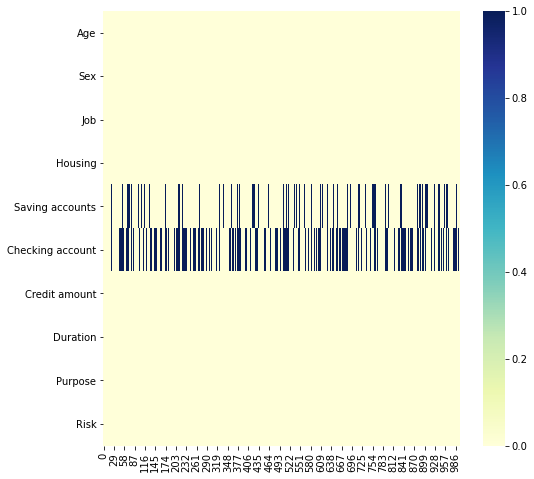

In [5]:
# checando a presença de valores nulos - forma gráfica
plt.figure(figsize=(8,8))
sns.heatmap(data.isna().T, cmap='YlGnBu')

In [6]:
# transformando feature target em números
data.Risk = data.Risk.map({'good': 0, 'bad': 1})
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,1


In [7]:
# analisando balanceamento de classes
data.Risk.value_counts()

0    700
1    300
Name: Risk, dtype: int64

In [8]:
# separando entre preditores e preditos
x = data.drop(['Risk'], axis = 1)
y = data[['Risk']]

# separando o conjunto de validação final
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

In [9]:
# configurando um objeto de pré-processamento completo
pipe_num = Pipeline([('input_na_num', SimpleImputer(strategy='mean'))])
pipe_cat = Pipeline([
    ('input_na_cat', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(drop='first'))
    ])

# selecionando automaticamente as colunas que vão receber os processamentos
num_features = x_train.select_dtypes(include = np.number).columns.tolist()
cat_features = x_train.select_dtypes(exclude = np.number).columns.tolist()

# criando o transformador de colunas
pre_processador = ColumnTransformer(
    [
        ('transf_num', pipe_num, num_features),
        ('transf_cat', pipe_cat, cat_features)
    ]
)

In [10]:
# configurando o amostrador
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

# configurando o pipeline final
final_pipe = Pipeline([
    ('preprocessador', pre_processador),
    ('scaler', StandardScaler()),
    ('ada', AdaBoostClassifier())
])

# dicionário de hiperparâmetros
param_dict = {
    'ada__n_estimators': np.random.randint(2, 1000, size = 500)
}

In [11]:
# definindo a função de lucro que usaremos como métrica
def lucro_f(y_real, y_pred):

    # cálculo da matriz de confusão
    cm = confusion_matrix(y_real, y_pred)

    # extração dos valores de falsos positivos e falsos negativos
    FP = cm[0][1]                # falsos positivos
    TP = cm[1][1]                # verdadeiros positivos
    TN = cm[0][0]                # verdadeiros negativos
    FN = cm[1][0]                # falsos negativos

    # cálculo do lucro segundo a regra de negócios
    # 100 euros por cliente verdadeiro positivo
    # -1500 euros por cliente falso positivo
    # 500 euros por cliente verdadeiro falso negativo
    # -50 euros por cliente falso negativo
    lucro = 100*TP - 150*FP + 500*TN - 50*FN

    return lucro

score_lucro = make_scorer(lucro_f, greater_is_better=True)

In [12]:
# criando o baseline - caso mais otimista
yhat_base = np.repeat(0, repeats=y_test.shape[0])

# lucro obtido com o baseline
print(f'Lucro Baseline - Caso Otimista: {lucro_f(y_test, yhat_base)}')

Lucro Baseline - Caso Otimista: 67000


In [13]:
# criando o baseline - caso mais pessimista
yhat_base = np.repeat(1, repeats=y_test.shape[0])

# lucro obtido com o baseline
print(f'Lucro Baseline - Caso Pessimista: {lucro_f(y_test, yhat_base)}')

Lucro Baseline - Caso Pessimista: -15000


In [14]:
# lucro máximo possível
print(y_test.value_counts())

print(f'Lucro Máximo: {500*140 + 100*60}')

Risk
0       140
1        60
dtype: int64
Lucro Máximo: 76000


In [15]:
# criando o amostrador para seleção dos hiperparâmetros
model_selector = RandomizedSearchCV(
    estimator=final_pipe,
    param_distributions=param_dict,
    scoring = score_lucro,
    n_iter=2,
    cv = cvs,
    refit = True 
)

model_selector.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessador',
                                              ColumnTransformer(transformers=[('transf_num',
                                                                               Pipeline(steps=[('input_na_num',
                                                                                                SimpleImputer())]),
                                                                               ['Age',
                                                                                'Job',
                                                                                'Credit '
                                                                                'amount',
                                                                                'Duration']),
                                                                              ('trans

In [16]:
# analisando o melhor modelo
print('Melhor parâmetro: ', model_selector.best_params_)
print('Maior lucro médio obtido: ', model_selector.best_score_)

Melhor parâmetro:  {'ada__n_estimators': 373}
Maior lucro médio obtido:  22720.0


In [17]:
# avaliando o relatório de classificação do ponto de vista do negócio
yhat = model_selector.best_estimator_.predict(x_test)

print(f'Lucro Esperado: {lucro_f(y_test, yhat)}')

Lucro Esperado: 54800


### Mas existe a possibilidade de tunarmos os parâmetros do modelo "fraco"?

In [18]:
# vamos criar um AdaBoost de regressões logísticas
base_model = LogisticRegression(solver='saga')

# recriando o pipeline do AdaBoost, explicitando o modelo base
final_pipe = Pipeline([
    ('preprocessador', pre_processador),
    ('scaler', StandardScaler()),
    ('ada', AdaBoostClassifier(base_estimator=base_model, random_state=19))
])

# dicionário de hiperparâmetros
param_dict = {
    'ada__base_estimator__C': np.random.uniform(0.01, 10, size = 1000),
    'ada__base_estimator__penalty': ['l1', 'l2', 'elasticnet'],
    'ada__base_estimator__l1_ratio': np.random.uniform(0.1, 1, size = 100),
    'ada__n_estimators': np.random.randint(2, 1000, size = 500)
}

In [19]:
# criando o amostrador para seleção dos hiperparâmetros
model_selector = RandomizedSearchCV(
    estimator=final_pipe,
    param_distributions=param_dict,
    scoring = score_lucro,
    n_iter=1,
    cv = cvs,
    refit = True,
    n_jobs = -1
)

# ajustando o modelo
model_selector.fit(x_train, y_train)

# analisando o melhor modelo
print('Melhor parâmetro: ', model_selector.best_params_)
print('Maior lucro obtido: ', model_selector.best_score_)

Melhor parâmetro:  {'ada__n_estimators': 939, 'ada__base_estimator__penalty': 'l2', 'ada__base_estimator__l1_ratio': 0.3486007277046319, 'ada__base_estimator__C': 8.117345559321906}
Maior lucro obtido:  23555.0


In [20]:
# avaliando o relatório de classificação do ponto de vista do negócio
yhat = model_selector.best_estimator_.predict(x_test)

print(f'Lucro Esperado: {lucro_f(y_test, yhat)}')

Lucro Esperado: 60700


___

## 3. *Gradient Boosting*

O AdaBoost não é o único que incorpora a técnica de boosting. Outro tipo de modelo que implementa é o Gradient Boosting, que implementa o princípio de boosting por meio de um **gradiente explícito**

<img src=https://miro.medium.com/max/788/1*pEu2LNmxf9ttXHIALPcEBw.png width=600>

A ideia é que caminhemos na direção do **erro mínimo** de maneira iterativa **passo a passo**.

Este caminho se dá justamente pelo **gradiente** da **função de custo/perda**, que mede justamente os erros cometidos.

<img src=https://upload.wikimedia.org/wikipedia/commons/a/a3/Gradient_descent.gif width=400>

Este método é conhecido como:

### Gradiente descendente

Deixei em ênfase porque este será um método de **enorme importância** no estudo de redes neurais (e é, em geral, um método de otimização muito utilizado).

O objetivo geral do método é bem simples: determinar quais são os **parâmetros** da hipótese que minimizam a função de custo/perda. Para isso, o método "percorre" a função de erro, indo em direção ao seu mínimo (e este "caminho" feito na função se dá justamente pela **determinação iterativa dos parâmetros**, isto é, **a cada passo, chegamos mais perto dos parâmetros finais da hipótese**, conforme eles são ajustados aos dados.

> **Pequeno interlúdio matemático:** o gradiente descendente implementado pelo gradient boosting é, na verdade, um **gradiente descendente funcional**, isto é, desejamos encontrar não um conjunto de parâmetros que minimiza o erro, mas sim **introduzir sequencialmente weak learners (hipótese simples) que minimizam o erro**. Desta forma, o gradient boosting minimiza a função de custo ao ecolher iterativamente hipóteses simples que apontam na direção do mínimo, neste espaço funcional.

Apesar do interlúdio acima, não precisamos nos preocupar muito com os detalhes matemáticos: o que importa é entender que no caso do gradient boosting, há alguns pontos importantes:

- Uma **função de custo/perda (loss)** é explicitamente minimizada por um procedimento de gradiente;

- O gradiente está relacionado com o procedimento de **encadeamento progressivo entre weak learners**, seguindo a ideia do boosting.

Pra quem quiser saber um pouco mais de detalhes (e se aventurar na matemática), sugiro [este post](https://www.gormanalysis.com/blog/gradient-boosting-explained/) ou então [este site](https://explained.ai/gradient-boosting/), que contém vários materiais ótimos para entender o método com todos os detalhes matemáticos.

Os [vídeos do StatQuest](https://www.youtube.com/playlist?list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6) também são uma boa referência

As classes do sklearn são:

- [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

- [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)

E os principais hiperparâmetros a serem ajustados são:

- `n_estimators` : novamente, o número de weak learners encadeados.

- `learning_rate` : a constante que multiplica o gradiente no gradiente descendente. Essencialmente, controla o "tamanho do passo" a ser dado em direção ao mínimo.

Segundo o próprio [User Guide](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting): "*Empirical evidence suggests that small values of `learning_rate` favor better test error. The lireature recommends to set the learning rate to a small constant (e.g. `learning_rate <= 0.1`) and choose `n_estimators` by early stopping.*"

Ainda sobre a learning rate, as ilustrações a seguir ajudam a entender sua importância:

<img src=https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png width=700>

<img src=https://cdn-images-1.medium.com/max/1440/0*A351v9EkS6Ps2zIg.gif width=500>

## 4. *EXtreme Gradient Boosting*

Este método nada mais é que um gradient boosting, mas com algumas importantes modificações que lhe conferem o título de "extreme"! Em particular, duas alterações merecem destaque:

- A adição de procedimentos de regularização (L1 e L2!), o que melhora consideravelmente sua capacidade de generalização;

- A utilização de derivadas de segunda ordem (Hessiano) para o procedimento de gradiente.

Para quem quiser se aventurar mais, sugiro algumas boas leituras:

- [Este](https://shirinsplayground.netlify.app/2018/11/ml_basics_gbm/), explica bem as particularidades do XGBoost, além de dar uma boa introdução ao gradient boosting

- [Este](https://medium.com/analytics-vidhya/what-makes-xgboost-so-extreme-e1544a4433bb), introduz bem o método, enquanto enfativa suas particularidades, com alguns detalhes matemáticos;

- [Este](https://xgboost.readthedocs.io/en/latest/tutorials/model.html), da própria documentação da biblioteca, traz uma explicação legal, e com alguns detalhes matemáticos;

- [Este](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d), com uma discussão mais alto-nível (sem tantos detalhes) sobre o XGBoost e os motivos de seu sucesso.

______

## Exercício 1

Aplicando os conhecimentos obtidos com os modelos de GradientBoosting e de XGBoost, tente melhorar o desempenho do classificador de crédito com relação ao lucro esperado. Lembre-se de checar a documentação para identificar os hiperparâmetros que podem ser trabalhados em cada um deles. Nesse exercício, utilize os estimadores padrão das respectivas classes.

_____

#### GradientBoosting Classifier

In [21]:
# configurando o amostrador
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

# configurando o pipeline final
final_pipe = Pipeline([
    ('preprocessador', pre_processador),
    ('scaler', StandardScaler()),
    ('gboost', GradientBoostingClassifier())
])

# dicionário de hiperparâmetros
param_dict = {
    'gboost__n_estimators': np.random.randint(20,1000,500),
    'gboost__learning_rate': np.random.uniform(0.01, 0.2, 100)
}

In [22]:
# criando o amostrador para seleção dos hiperparâmetros
model_selector = RandomizedSearchCV(
    estimator=final_pipe,
    param_distributions=param_dict,
    scoring = score_lucro,
    n_iter=1,
    cv = cvs,
    refit = True,
    n_jobs = -1 
)

# ajustando o modelo 
model_selector.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessador',
                                              ColumnTransformer(transformers=[('transf_num',
                                                                               Pipeline(steps=[('input_na_num',
                                                                                                SimpleImputer())]),
                                                                               ['Age',
                                                                                'Job',
                                                                                'Credit '
                                                                                'amount',
                                                                                'Duration']),
                                                                              ('trans

In [23]:
# analisando o melhor modelo
print('Melhor parâmetro: ', model_selector.best_params_)
print('Maior lucro médio obtido: ', model_selector.best_score_)

# avaliando o relatório de classificação do ponto de vista do negócio
yhat = model_selector.best_estimator_.predict(x_test)

print(f'Lucro Esperado: {lucro_f(y_test, yhat)}')

Melhor parâmetro:  {'gboost__n_estimators': 236, 'gboost__learning_rate': 0.029140058944047947}
Maior lucro médio obtido:  24440.0
Lucro Esperado: 64050


#### XGBoost Classifier

In [24]:
# configurando o amostrador
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

# configurando o pipeline final
final_pipe = Pipeline([
    ('preprocessador', pre_processador),
    ('scaler', StandardScaler()),
    ('xgboost', xgb.XGBClassifier())
])

# dicionário de hiperparâmetros
param_dict = {
    'xgboost__eta': np.random.uniform(0.01, 0.2, 100),
    'xgboost__max_depth': np.random.randint(1,20,500)
}

In [25]:
# criando o amostrador para seleção dos hiperparâmetros
model_selector = RandomizedSearchCV(
    estimator=final_pipe,
    param_distributions=param_dict,
    scoring = score_lucro,
    n_iter=1,
    cv = cvs,
    refit = True,
    n_jobs=-1
)

# ajustando o modelo 
model_selector.fit(x_train, y_train)

[11:29:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessador',
                                              ColumnTransformer(transformers=[('transf_num',
                                                                               Pipeline(steps=[('input_na_num',
                                                                                                SimpleImputer())]),
                                                                               ['Age',
                                                                                'Job',
                                                                                'Credit '
                                                                                'amount',
                                                                                'Duration']),
                                                                              ('trans

In [26]:
# analisando o melhor modelo
print('Melhor parâmetro: ', model_selector.best_params_)
print('Maior lucro médio obtido: ', model_selector.best_score_)

# avaliando o relatório de classificação do ponto de vista do negócio
yhat = model_selector.best_estimator_.predict(x_test)

print(f'Lucro Esperado: {lucro_f(y_test, yhat)}')

Melhor parâmetro:  {'xgboost__max_depth': 3, 'xgboost__eta': 0.1000977009773678}
Maior lucro médio obtido:  24160.0
Lucro Esperado: 62850


____

## Exercício 2

Repita o exercício dois, porém modificando o estimador base, conforme fizemos na demonstração, alterando seus hiperparâmetros também. **ATENÇÃO**: no caso do xgboost, isso deve ser feito de forma separada, ou seja, haverá um pipeline com o parâmetros `gbtree` e outro com o `gblinear`.

______

#### GradientBoosting Classifier

In [27]:
# vamos criar um AdaBoost de regressões logísticas
base_model = LogisticRegression(solver='saga')

# recriando o pipeline do AdaBoost, explicitando o modelo base
final_pipe = Pipeline([
    ('preprocessador', pre_processador),
    ('scaler', StandardScaler()),
    ('gboost', GradientBoostingClassifier(init=base_model, 
                                          random_state=19))
])

# dicionário de hiperparâmetros
param_dict = {
    'gboost__init__C': np.random.uniform(0.01, 10, size = 1000),
    'gboost__init__penalty': ['l1', 'l2', 'elasticnet'],
    'gboost__init__l1_ratio': np.random.uniform(0.1, 1, size = 100),
    'gboost__n_estimators': np.random.randint(2, 1000, size = 500)
}

In [28]:
# criando o amostrador para seleção dos hiperparâmetros
model_selector = RandomizedSearchCV(
    estimator=final_pipe,
    param_distributions=param_dict,
    scoring = score_lucro,
    n_iter=1,
    cv = cvs,
    refit = True,
    n_jobs = -1
)

# ajustando o modelo
model_selector.fit(x_train, y_train)

# analisando o melhor modelo
print('Melhor parâmetro: ', model_selector.best_params_)
print('Maior lucro obtido: ', model_selector.best_score_)

# avaliando o relatório de classificação do ponto de vista do negócio
yhat = model_selector.best_estimator_.predict(x_test)

print(f'Lucro Esperado: {lucro_f(y_test, yhat)}')

Melhor parâmetro:  {'gboost__n_estimators': 648, 'gboost__init__penalty': 'l2', 'gboost__init__l1_ratio': 0.687757239065349, 'gboost__init__C': 1.8441642854095688}
Maior lucro obtido:  22955.0
Lucro Esperado: 56700


#### XGBoost Classifier Linear

In [29]:
# configurando o amostrador
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

# configurando o pipeline final
final_pipe = Pipeline([
    ('preprocessador', pre_processador),
    ('scaler', StandardScaler()),
    ('xgboost', xgb.XGBClassifier(booster='gblinear'))
])

# dicionário de hiperparâmetros
param_dict = {
    'xgboost__eta': np.random.uniform(0.01, 0.2, 100),
    'xgboost__lambda': np.random.randint(0.1,10,500)
}

In [30]:
# criando o amostrador para seleção dos hiperparâmetros
model_selector = RandomizedSearchCV(
    estimator=final_pipe,
    param_distributions=param_dict,
    scoring = score_lucro,
    n_iter=1,
    cv = cvs,
    refit = True,
    n_jobs = -1
)

# ajustando o modelo
model_selector.fit(x_train, y_train)

# analisando o melhor modelo
print('Melhor parâmetro: ', model_selector.best_params_)
print('Maior lucro obtido: ', model_selector.best_score_)

# avaliando o relatório de classificação do ponto de vista do negócio
yhat = model_selector.best_estimator_.predict(x_test)

print(f'Lucro Esperado: {lucro_f(y_test, yhat)}')

[11:29:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Melhor parâmetro:  {'xgboost__lambda': 8, 'xgboost__eta': 0.03667516869495077}
Maior lucro obtido:  26800.0
Lucro Esperado: 67000


## Exercício 3 (DESAFIO)

Agora é com vocês ! Existe uma base de dados que descrever a produtividade de uma indústria, portanto sendo um problema de regressão. Nessa atividade você deverá:

- carregar a base de dados
- identificar a necessidade de tratar dados nulos
- calcule o lucro no pior cenário, melhor cenário e no cenário "ingênuo" - mais detalhes da função lucro abaixo
- configurar um processador de dados usando o `ColumnTransformer`, `SimpleImputer` e `Pipeline`, conform você determinar
- separar uma base de treino e de teste, colocando 30 % para base de teste, sem estratificação
- configure um amostrador de validação cruzada de 5 folds sem estratificação (`KFold`)
- configure um `Pipeline` com o processamento, scaler (`StandardScaler`) e o modelo selecionado
- use um seletor de modelos `RandomizedSearchCV`
- teste os modelos `AdaBoostRegressor`, `GradientBoostingRegressor`, `XGBoostRegressor`
- você tem a liberdade de escolher os hiperparâmetros e estimadores base
- aplique a seguinte regra de negócios numa função para determinar o lucro

    - se o erro for menor que -10 % em relação ao valor, deve-se pagar a execução do modelo (150) e o prejuízo de superestimar (p*2500)
    - se o erro ficar entre -10 % e -1 % em relação ao valor, paga-se a execução do modelo (150) e metade do prejuízo (p*1250)
    - se o erro ficar entre -1 % e + 1 % em relação ao valor, paga-se a execução do modelo (150)
    - se o erro ficar entre 1 % e e 10 %, paga-se o modelo (150) porém ganha-se metade do lucro total (p*1000)
    - se o erro for maior que 10 %, paga-se o modelo (150) porém se ganha o lucro total (p*2000)



In [31]:
def penalty(x):
    if x < -0.1:
        return -2500
    elif ((x >= -0.1) & (x < -0.01)):
        return -1250
    elif ((x >= -0.01) & (x < 0.01)):
        return 0
    elif ((x >= 0.01) & (x < 0.1)):
        return 1000
    else:
        return 2000

In [32]:
def lucro_f(y_real, ypred):
    data = pd.DataFrame(y_real.values, columns = ['real'])
    data['pred'] = ypred

    data['erro_p'] = (data['real'] - data['pred']) / data['real']

    data['penalty'] = data.erro_p.apply(penalty)
    data['penalty'] -= 150

    print(data.head())

    return data.penalty.sum()

In [33]:
# importar a base de dados
data = pd.read_csv('garments_worker_productivity.csv')
data.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [34]:
# identificar a necessidade de tratamento de dados nulos
data.isna().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

In [35]:
# tranformando tipos dos dados do número do time
data.team = data.team.astype('str')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   object 
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [36]:
# separando entre preditores e preditos
x = data.drop(['date', 'actual_productivity'], axis = 1)
y = data[['actual_productivity']]

# separando o conjunto de validação final
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [37]:
# configurando um objeto de pré-processamento completo
pipe_num = Pipeline([('input_na_num', SimpleImputer(strategy='mean'))])
pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
    ])

# selecionando automaticamente as colunas que vão receber os processamentos
num_features = x_train.select_dtypes(include = np.number).columns.tolist()
cat_features = x_train.select_dtypes(exclude = np.number).columns.tolist()

# criando o transformador de colunas
pre_processador = ColumnTransformer(
    [
        ('transf_num', pipe_num, num_features),
        ('transf_cat', pipe_cat, cat_features)
    ]
)

#### AdaBoostRegressor

In [38]:
# configurando o amostrador
cvs = KFold(n_splits=5, shuffle=True, random_state=2)

# configurando o pipeline final
final_pipe = Pipeline([
    ('preprocessador', pre_processador),
    ('scaler', StandardScaler()),
    ('ada', AdaBoostRegressor())
])

# dicionário de hiperparâmetros
param_dict = {
    'ada__n_estimators': np.random.randint(2, 1000, size = 500)
}

In [39]:
# criando o amostrador para seleção dos hiperparâmetros
model_selector = RandomizedSearchCV(
    estimator=final_pipe,
    param_distributions=param_dict,
    scoring = make_scorer(lucro_f, greater_is_better=True),
    n_iter=1,
    cv = cvs,
    refit = True,
    n_jobs = -1
)

# ajustando o modelo
model_selector.fit(x_train, y_train)

# analisando o melhor modelo
print('Melhor parâmetro: ', model_selector.best_params_)
print('Maior lucro obtido: ', model_selector.best_score_)

# avaliando o relatório de classificação do ponto de vista do negócio
yhat = model_selector.best_estimator_.predict(x_test)

print(f'Lucro Esperado: {lucro_f(y_test, yhat)}')

Melhor parâmetro:  {'ada__n_estimators': 164}
Maior lucro obtido:  55040.0
       real      pred    erro_p  penalty
0  0.268214  0.526517 -0.963045    -2650
1  0.800359  0.803737 -0.004221     -150
2  0.681061  0.669640  0.016769      850
3  0.325000  0.624429 -0.921319    -2650
4  0.667604  0.667264  0.000509     -150
Lucro Esperado: 132500


In [40]:
# pior caso - todos os erros abaixo de -10 % 
df_lucro = y_test.copy()

df_lucro['pior_caso'] = 1

print(f'Lucro no Pior Caso: {lucro_f(df_lucro["actual_productivity"], df_lucro["pior_caso"].values)}')

       real  pred    erro_p  penalty
0  0.268214     1 -2.728362    -2650
1  0.800359     1 -0.249440    -2650
2  0.681061     1 -0.468298    -2650
3  0.325000     1 -2.076923    -2650
4  0.667604     1 -0.497894    -2650
Lucro no Pior Caso: -870250


In [41]:
# melhor caso - todos os erros acima de 10 % 
df_lucro = y_test.copy()

df_lucro['melhor_caso'] = 0

print(f'Lucro no melhor Caso: {lucro_f(df_lucro["actual_productivity"], df_lucro["melhor_caso"].values)}')

       real  pred  erro_p  penalty
0  0.268214     0     1.0     1850
1  0.800359     0     1.0     1850
2  0.681061     0     1.0     1850
3  0.325000     0     1.0     1850
4  0.667604     0     1.0     1850
Lucro no melhor Caso: 666000


## Mas e se quisermos avaliar o modelo classificador de uma forma mais "humana"? 

Não faz mais sentido decidir pela inadimplência olhando a chance da pessoa ser de fato inadimplente? 

-   Mas isso envolve escolher qual seria a probabilidade mínima de decisão. Conseguimos analisar qual o impacto dessa decisão?

In [42]:
# importando os dados
data = pd.read_csv('german_credit_data.csv')
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [43]:
# eliminando colunas não utilizadas
data.drop(['Unnamed: 0'], inplace=True, axis = 1)

In [44]:
# transformando feature target em números
data.Risk = data.Risk.map({'good': 0, 'bad': 1})
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,1


In [45]:
# separando entre preditores e preditos
x = data.drop(['Risk'], axis = 1)
y = data[['Risk']]

# separando o conjunto de validação final
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

In [46]:
# configurando um objeto de pré-processamento completo
pipe_num = Pipeline([('input_na_num', SimpleImputer(strategy='mean'))])
pipe_cat = Pipeline([
    ('input_na_cat', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(drop='first'))
    ])

# selecionando automaticamente as colunas que vão receber os processamentos
num_features = x_train.select_dtypes(include = np.number).columns.tolist()
cat_features = x_train.select_dtypes(exclude = np.number).columns.tolist()

# criando o transformador de colunas
pre_processador = ColumnTransformer(
    [
        ('transf_num', pipe_num, num_features),
        ('transf_cat', pipe_cat, cat_features)
    ]
)

In [47]:
# configurando o amostrador
cvs = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

# configurando o pipeline final
final_pipe = Pipeline([
    ('preprocessador', pre_processador),
    ('scaler', StandardScaler()),
    ('gboost', GradientBoostingClassifier())
])

# dicionário de hiperparâmetros
param_dict = {
    'gboost__n_estimators': np.random.randint(20,100,50),
    'gboost__learning_rate': np.random.uniform(0.01, 0.2, 100)
}

In [48]:
# definindo a função de lucro que usaremos como métrica
def lucro_f_prob(y_real, y_pred, prob_thresh):

    # criar um dataframe
    prob_data = pd.DataFrame(y_real.values, columns = ['prob_real'])
    prob_data['prob_pred'] = y_pred

    # aplica a regra de decisão
    prob_data.class_real = prob_data.prob_real.apply(lambda x: 1 if x > prob_thresh else 0)
    prob_data.class_pred = prob_data.prob_pred.apply(lambda x: 1 if x > prob_thresh else 0)

    # cálculo da matriz de confusão
    cm = confusion_matrix(prob_data.class_real, prob_data.class_pred)

    # extração dos valores de falsos positivos e falsos negativos
    FP = cm[0][1]                # falsos positivos
    TP = cm[1][1]                # verdadeiros positivos
    TN = cm[0][0]                # verdadeiros negativos
    FN = cm[1][0]                # falsos negativos

    # cálculo do lucro segundo a regra de negócios
    # 100 euros por cliente verdadeiro positivo
    # -1500 euros por cliente falso positivo
    # 500 euros por cliente verdadeiro falso negativo
    # -50 euros por cliente falso negativo
    lucro = 100*TP - 150*FP + 500*TN - 50*FN

    return lucro

In [49]:
# criar um vetor de probabilidades a serem testadas
prob_test = np.arange(0.1, 1, 0.1)

# criando listas vazias
avg_lucro = []
test_lucro = []

# iterar para avaliar os modelos treinados
for p in prob_test:

    # treinar o modelo em CV
    model_selector = RandomizedSearchCV(
    estimator=final_pipe,
    param_distributions=param_dict,
    scoring = make_scorer(lucro_f_prob, 
                          greater_is_better=True, 
                          needs_proba=True, 
                          prob_thresh = p),
    n_iter=3,
    cv = cvs,
    refit = True,
    n_jobs = -1 
    )

    # ajustando o modelo 
    model_selector.fit(x_train, y_train)

    # obtendo as métricas médias
    # filtrando nans
    avgs = [m for m in model_selector.cv_results_['mean_test_score'] if str(m).lower() != 'nan']
    avg_lucro.append(np.mean(avgs))

    # usando o melhor estimador encontrado para realizar novas previsões na base de teste
    yhat = model_selector.best_estimator_.predict_proba(x_test)

    # obtendo as probabilidades de pertencimento à classe 1
    pred_prob = []
    for y in yhat:
        pred_prob.append(y[1])

    # calculando a métrica na base de teste
    test_lucro.append(lucro_f_prob(y_test, pred_prob, prob_thresh=p))

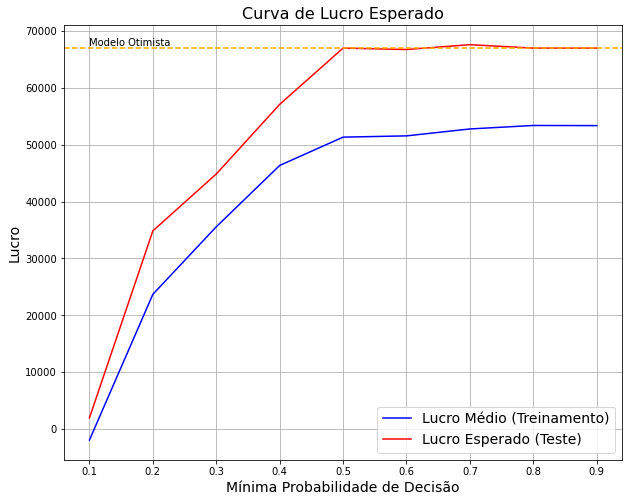

In [50]:
plt.figure(figsize=(10,8))
plt.plot(prob_test, avg_lucro, 'b-', label = 'Lucro Médio (Treinamento)')
plt.plot(prob_test, test_lucro, 'r-', label = 'Lucro Esperado (Teste)')
plt.xlabel('Mínima Probabilidade de Decisão', size = 14)
plt.ylabel('Lucro', size = 14)
plt.title('Curva de Lucro Esperado', size = 16)
plt.legend(loc = 'best', prop={'size':14})
plt.axhline(y = 67000, color = 'orange', ls = '--')
plt.annotate(s = 'Modelo Otimista', xy = (0.1, 67500))
plt.grid()
plt.show()